In [34]:
# File for data cleaning
import pandas as pd

In [35]:
full_df = pd.read_csv("Wimbledon_featured_matches.csv")

In [36]:
def get_row_momentum(row):
    # p1_momentum = 0
    # p2_momentum = 0
    momentum_dict = {"1": 0, "2": 0}
    score_point_diff_p1 = row["p1_points_won"] - row["p2_points_won"]
    score_point_diff_p2 = -score_point_diff_p1
    p1_break_serve = (
        1 if (row["server"] == 2).all() and (row[f"p2_ace"] != 1).all() else 0
    )
    p2_break_serve = (
        1 if (row["server"] == 1).all() and (row[f"p1_ace"] != 1).all() else 0
    )
    row["serve_player1_broken"] = p1_break_serve
    row["serve_player2_broken"] = p2_break_serve
    row["p1_point_diff"] = score_point_diff_p1
    row["p2_point_diff"] = score_point_diff_p2

    for i in ["1", "2"]:
        not_i = "1" if i == "2" else "2"
        if row[f"p{i}_ace"].any():
            momentum_dict[i] += 1
            momentum_dict[not_i] -= 1
        if row[f"p{i}_winner"].any():
            momentum_dict[i] += 2
            momentum_dict[not_i] -= 1
        if row[f"p{i}_double_fault"].any():
            momentum_dict[i] -= 1
            momentum_dict[not_i] += 1
        if row[f"p{i}_break_pt_won"].any():
            momentum_dict[i] += 1
            momentum_dict[not_i] -= 1
        if row[f"p{i}_break_pt_missed"].any():
            momentum_dict[i] -= 1
            momentum_dict[not_i] += 1
        if row[f"p{i}_unf_err"].any():
            momentum_dict[i] -= 2
            momentum_dict[not_i] += 1
        if (row[f"p{i}_point_diff"] > 2).any() and (row[f"p{not_i}_winner"]).any():
            momentum_dict[i] -= 3
            momentum_dict[not_i] += 1
        if (row[f"serve_player{i}_broken"]).any():
            momentum_dict[i] -= 1
            momentum_dict[not_i] += 1
        # Maybe add something to make sure momentum does not 100% carry over

    row["p1_momentum"] = momentum_dict["1"]
    row["p2_momentum"] = momentum_dict["2"]
    return row

In [37]:
# For NOW ONLY GAME
columns = [
    "match_id",
    "player1",
    "player2",
    "elapsed_time",
    "set_no",
    "game_no",
    "point_no",
    "p1_sets",
    "p2_sets",
    "p1_games",
    "p2_games",
    "p1_points_won",
    "p2_points_won",
    "server",
    "speed_mph",
    "serve_width",
    "serve_depth",
    "return_depth",
    "serve_player1_broken",
    "serve_player2_broken",
    "p1_point_diff",
    "p2_point_diff",
    "p1_momentum",
    "p2_momentum",
]


def get_game_momentum(df):
    # df_set = df.loc[::, df["set"] == set_num]
    new_df = pd.DataFrame(columns=columns)
    p1_game_momentum = 0
    p2_game_momentum = 0
    for index, row in df.iterrows():
        row = pd.DataFrame(row).transpose()
        new_row = get_row_momentum(row).copy()
        p1_game_momentum += new_row["p1_momentum"].item()
        p2_game_momentum += new_row["p2_momentum"].item()
        a = new_row["p1_momentum"]
        # print(f"p1 gMom: {p1_game_momentum}|p1 rowMOM : {a}")
        new_row["p1_cumulative_momentum"] = p1_game_momentum
        new_row["p2_cumulative_momentum"] = p2_game_momentum
        new_df = pd.concat([new_df, new_row])
    return new_df

In [38]:
test_df = full_df.loc[full_df["match_id"] == "2023-wimbledon-1301"]
game_df = get_game_momentum(test_df)
game_df

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt,p1_break_pt_won,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,p1_cumulative_momentum,p2_cumulative_momentum
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,0,0,6.0,7.84,2,-1.0,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,0,0,5.253,7.094,1,0.0,-1.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,0,0,13.8,19.808,4,-1.0,-1.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,0,0,51.108,75.631,13,2.0,-3.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0,0,0.649,0.813,1,5.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,03:53:25,4,12,296,2,1,6,...,0,0,0,0,0,10.044,9.281,2,-55.0,11.0
296,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,03:54:01,4,12,297,2,1,6,...,0,0,0,0,0,52.318,58.723,14,-58.0,13.0
297,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,03:55:02,4,12,298,2,1,6,...,1,0,0,0,1,2.056,1.509,1,-56.0,11.0
298,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,03:55:34,4,12,299,2,1,6,...,0,0,0,0,0,12.292,32.582,1,-55.0,10.0


In [39]:
columns = [
    "match_id",
    "player1",
    "player2",
    "elapsed_time",
    "set_no",
    "game_no",
    "point_no",
    "p1_sets",
    "p2_sets",
    "p1_games",
    "p2_games",
    "p1_points_won",
    "p2_points_won",
    "server",
    "speed_mph",
    "serve_width",
    "serve_depth",
    "return_depth",
    "serve_player1_broken",
    "serve_player2_broken",
    "p1_point_diff",
    "p2_point_diff",
    "p1_momentum",
    "p2_momentum",
    "p1_cumulative_momentum",
    "p2_cumulative_momentum",
]


def create_df(df):
    new_df = pd.DataFrame(columns=columns)
    for id in df["match_id"].unique():
        # print(id)
        tmp = df.loc[df["match_id"] == id].copy()
        # print(tmp)
        game_df = get_game_momentum(tmp)
        new_df = pd.concat([new_df, game_df])
    return new_df

In [40]:
# new_full_df = create_df(full_df) # DO NOT RUN

In [41]:
# new_full_df.to_excel("output.xlsx", index=False)  # DO NOT RUN

In [42]:
import matplotlib.pyplot as plt

In [43]:
x = game_df["elapsed_time"]
y1 = game_df["p1_cumulative_momentum"]
y2 = game_df["p2_cumulative_momentum"]
y3 = game_df["p1_games"]
y4 = game_df["p2_games"]
y5 = game_df["p1_sets"]
y6 = game_df["p2_sets"]

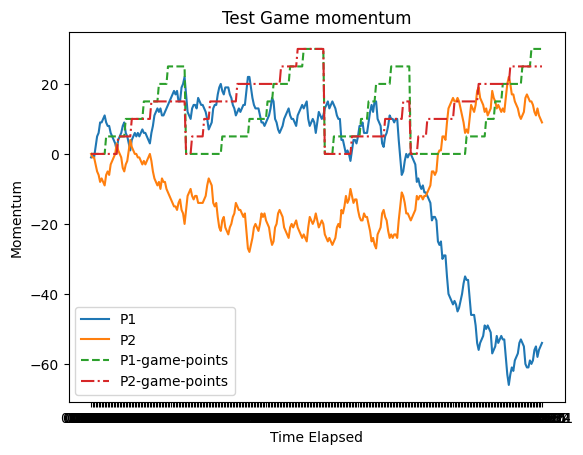

In [44]:
plt.plot(x, y1)
plt.plot(x, y2)


plt.plot(x, y3 * 5, linestyle="--")


plt.plot(x, y4 * 5, linestyle="-.")


# plt.plot(x, y5 * 10, linestyle=":")

# plt.plot(x, y6 * 10, linestyle=":")

plt.xlabel("Time Elapsed")
plt.ylabel("Momentum")
plt.title("Test Game momentum")
# , "P1- set", "P2 -set"])
plt.legend(["P1", "P2", "P1-game-points", "P2-game-points"])

plt.show()